# Analysis

## env vars

In [5]:
from dotenv import load_dotenv
import os

# Load .env file
load_dotenv()

# Get client ID and secret
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')

## input data

In [6]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials

authorization_code_flow = True
client_credentials_flow = not authorization_code_flow

if authorization_code_flow:
    scope = "playlist-read-private playlist-modify-private user-library-read playlist-modify-public"
    sp = spotipy.Spotify(
        auth_manager=SpotifyOAuth(
            client_id=client_id,
            client_secret=client_secret,
            scope=scope,
            redirect_uri="http://localhost:3000",
        )
    )
else:
    sp = spotipy.Spotify(
        auth_manager=SpotifyClientCredentials(
            client_id=client_id,
            client_secret=client_secret,
        )
    )


In [7]:
import pandas as pd
import time

# Get user's playlists
playlists = sp.current_user_playlists()

# Get the tracks from the playlists in the "Rated" folder
tracks = []
for playlist in playlists['items']:
    if playlist['name'] in ["0.0", "0.5", "1.0", "1.5", "2.0", "2.5", "3.0", "3.5", "4.0", "4.5", "5.0"]:
        playlist_id = playlist['id']
        results = sp.playlist_tracks(playlist_id)
        track_ids = [item['track']['id'] for item in results['items']]
        
        # Get audio features for each track
        num_tracks_to_fetch = 100  # Maximum number of tracks to fetch at once
        for i in range(0, len(track_ids), num_tracks_to_fetch):
            audio_features_list = sp.audio_features(track_ids[i:i+num_tracks_to_fetch])
            
            # Implement rate limiting
            time.sleep(1)  # Delay for 1 second between requests
            
            for track, audio_features in zip(results['items'][i:i+num_tracks_to_fetch], audio_features_list):
                track = track['track']
                # Merge track and its audio features
                track.update(audio_features)
                # Add rating to track
                track['rating'] = float(playlist['name'])  # Convert the playlist name to float and use it as the rating
                tracks.append(track)
                print(f"{i}/{len(track_ids)} tracks done")
        print(f"Playlist {playlist['name']} done")

# save tracks to csv
df = pd.DataFrame(tracks)
df.to_csv('rated.csv')


0/1 tracks done
Playlist 1.0 done
0/2 tracks done
0/2 tracks done
Playlist 1.5 done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
0/66 tracks done
50/66 tracks done
50/66 tracks done
50/66 tracks done
50/66 tracks

## output data

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Load data
tracks_df = pd.read_csv('rated.csv')

# Preprocess data
tracks_df = tracks_df.dropna()  # Drop rows with missing values
tracks_df = pd.get_dummies(tracks_df)  # One-hot encode categorical data

# Define your target variable
target = 'rating'  # Replace this with the column that represents the rating of a track

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    tracks_df.drop(target, axis=1), tracks_df[target], test_size=0.2
)

# Train model
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

## error

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions
predictions = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2 Score): {r2}')

Mean Absolute Error (MAE): 0.14671641791044773
Mean Squared Error (MSE): 0.25064402985074624
R-squared (R2 Score): 0.6655844702035965


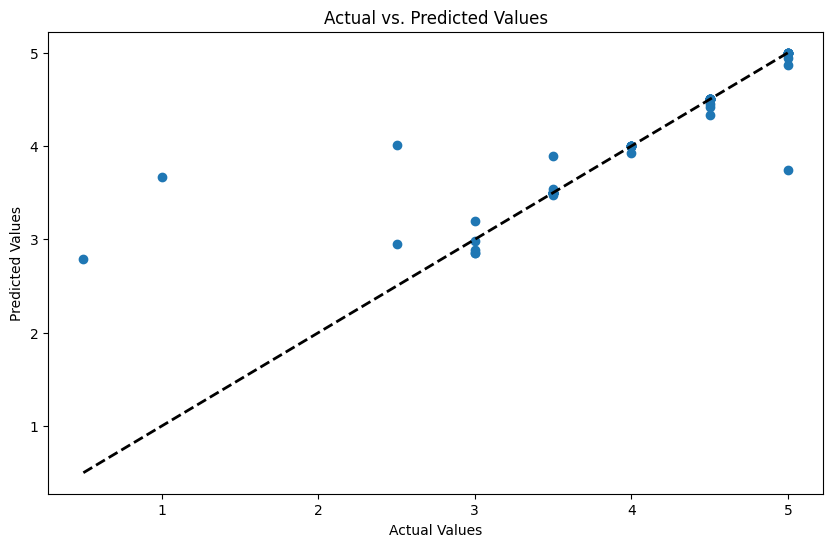

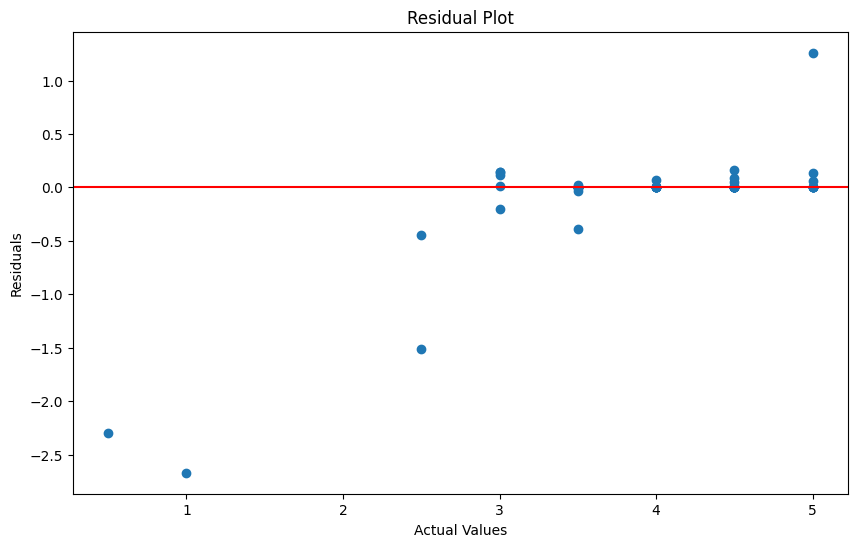

In [10]:
import matplotlib.pyplot as plt

# Make predictions
predictions = model.predict(X_test)

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

# Add y=x line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.show()

# Residual plot
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Give Recommendations to Users Based on Their Preferences

## load unrated songs

In [11]:
sources_ids = [
    "37i9dQZEVXcToZ9oox3nki",
    "37i9dQZF1DWZdLqpoFOt65",
    "37i9dQZEVXbn0l6flXloCt",
    "37i9dQZF1DWW1yuCSjnKtM",
    "22mm5J4DcucnRDLv0BAvti",
    "1h419AHuvIuFXjUjndFC25",
]
# discover weekly, for you., release radar, !!!, discover weekly (cash), discovered weekly (trending.)

In [12]:
import os
import pandas as pd

# Load rated songs
rated_songs = pd.read_csv('rated.csv') if os.path.exists('rated.csv') and os.path.getsize('rated.csv') > 0 else pd.DataFrame()

# Load unrated songs if exists
unrated_songs = pd.read_csv('unrated.csv') if os.path.exists('unrated.csv') and os.path.getsize('unrated.csv') > 0 else pd.DataFrame()

tracks = []

for playlist_id in sources_ids:
    results = sp.playlist(playlist_id)
    track_ids = [item['track']['id'] for item in results["tracks"]["items"] if item['track'] is not None and 'id' in item['track']]

    # Get audio features for each track
    for i in range(0, len(track_ids), 100):
        audio_features_list = sp.audio_features(track_ids[i:i+100])
        for track, audio_features in zip(results['tracks']['items'][i:i+100], audio_features_list):
            track = track['track']
            
            # Skip if the track is None or if 'id' key doesn't exist in track
            if track is None or 'id' not in track:
                continue
            
            # Skip if 'id' is in the rated songs or unrated songs
            if 'id' in rated_songs.columns and track['id'] in rated_songs['id'].values:
                continue
            if 'id' in unrated_songs.columns and track['id'] in unrated_songs['id'].values:
                continue
            
            # Append track details and audio features to the list
            tracks.append({
                'id': track['id'],
                'name': track['name'],
                'artist': track['artists'][0]['name'],
                'album': track['album']['name'],
                'release_date': track['album']['release_date'],
                'duration_ms': track['duration_ms'],
                'popularity': track['popularity'],
                **audio_features
            })
            print(f"Processed {len(tracks)} tracks", end="\r")

# Convert to DataFrame and save to CSV
tracks_df = pd.DataFrame(tracks)
tracks_df.to_csv("unrated.csv", index=False)

## recommend songs

In [13]:
# Set display options
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', 199)  # or 199

# Load data of unrated songs
unrated_songs = pd.read_csv('unrated.csv')

# Keep a copy of song names, artist, album, and id
song_data = unrated_songs[["name", "artist", "album", "id"]]

# Preprocess data
unrated_songs = unrated_songs.dropna()  # Drop rows with missing values
unrated_songs = pd.get_dummies(unrated_songs.drop(["name", "artist", "album", "id"], axis=1))  # One-hot encode categorical data excluding song data

# Make sure the unrated songs data has the same columns as the training data
missing_cols = set(X_train.columns) - set(unrated_songs.columns)
missing_df = pd.DataFrame(0, index=unrated_songs.index, columns=list(missing_cols))
unrated_songs = pd.concat([unrated_songs, missing_df], axis=1)
unrated_songs = unrated_songs[X_train.columns]

# Predict ratings of unrated songs
predicted_ratings = model.predict(unrated_songs)

# Add predicted ratings and song data to unrated songs data
unrated_songs['predicted_rating'] = predicted_ratings
unrated_songs = pd.concat([unrated_songs, song_data], axis=1)

# Create Spotify link using the song's ID
unrated_songs['spotify_link'] = 'https://open.spotify.com/track/' + unrated_songs['id']

# Recommend the top 10 songs with the highest predicted ratings
recommended_songs = unrated_songs.nlargest(10, 'predicted_rating')

# Reset index and print recommended songs
recommended_songs = recommended_songs.reset_index(drop=True)

# Display the table
recommended_songs[["name", "artist", "album", "spotify_link", "predicted_rating"]]

EmptyDataError: No columns to parse from file

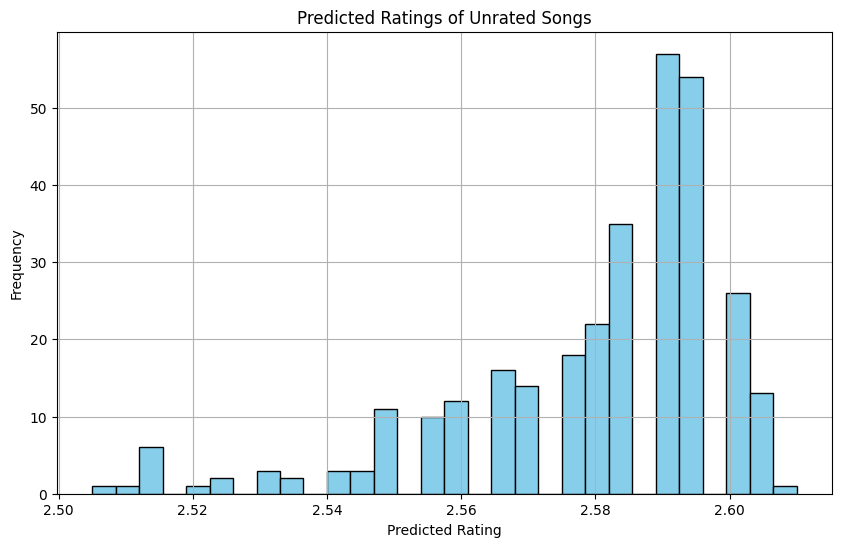

In [ ]:
# Load data of unrated songs
unrated_songs = pd.read_csv('unrated.csv')

# Keep a copy of song names, artist, album, and id
song_data = unrated_songs[["name", "artist", "album", "id"]]

# Preprocess data
unrated_songs = unrated_songs.dropna()  # Drop rows with missing values
unrated_songs = pd.get_dummies(unrated_songs.drop(["name", "artist", "album", "id"], axis=1))  # One-hot encode categorical data excluding song data

# Make sure the unrated songs data has the same columns as the training data
missing_cols = set(X_train.columns) - set(unrated_songs.columns)
missing_df = pd.DataFrame(0, index=unrated_songs.index, columns=list(missing_cols))
unrated_songs = pd.concat([unrated_songs, missing_df], axis=1)
unrated_songs = unrated_songs[X_train.columns]

# Predict ratings of unrated songs
predicted_ratings = model.predict(unrated_songs)

# Add predicted ratings and song data to unrated songs data
unrated_songs['predicted_rating'] = predicted_ratings
unrated_songs = pd.concat([unrated_songs, song_data], axis=1)

# Plot a graph of the predicted ratings
plt.figure(figsize=(10, 6))
plt.hist(unrated_songs['predicted_rating'], bins=30, color='skyblue', edgecolor='black')
plt.title('Predicted Ratings of Unrated Songs')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()